In [1]:
import os, sys, glob
import shutil, subprocess, shlex
import math
import numpy as np
import pandas as pd
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import deque
import itertools
from itertools import cycle

plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"
sns.set_style("whitegrid")

orderchrs = (lambda y : int(''.join([l for l in y if l.isdigit()])))

In [2]:
# Read CNAs from ASCAT

cnas = {}
plopur = {}
with open('data/cnas.csv') as i:
    for idx, line in enumerate(i):
        if 0 <= idx <= 9:
            assert line[0] == '#'
        elif idx == 10:
            assert line.split()[0] == 'sample'
        else:
            parsed = line.strip().split()
            patient = parsed[0].split('-')[0]
            sample = parsed[0].split('-')[1]
            
            ch = parsed[1]
            assert int(ch) in range(1, 25), ch
            
            seg = (int(parsed[2]), int(parsed[3]))
            assert seg[0] >= 0 and seg[1] >= 0
            
            cnstate = (int(parsed[6]), int(parsed[7]))
            assert cnstate[0] >= 0 and cnstate[1] >= 0 and sum(cnstate) == int(parsed[5])
            
            ploidy = float(parsed[8])
            
            purity = float(parsed[9])
            assert 0.0 <= purity <= 1.0
            
            if patient not in cnas:
                cnas[patient] = {}
                plopur[patient] = {}
                
            if sample not in cnas[patient]:
                cnas[patient][sample] = {}
                plopur[patient][sample] = {'ploidy' : ploidy, 'purity' : purity}
            else:
                assert plopur[patient][sample]['ploidy'] == ploidy
                assert plopur[patient][sample]['purity'] == purity
                
            if ch not in cnas[patient][sample]:
                cnas[patient][sample][ch] = {}
                
            chseg = sorted(cnas[patient][sample][ch], key=(lambda x : x[0]), reverse=True)
            for u in chseg:
                assert u[0] <= u[1] <= seg[0] or seg[1] <= u[0] <= u[1]
                if seg[1] <= u[0] <= u[1]:
                    break
            cnas[patient][sample][ch][seg] = cnstate

In [3]:
# General statistics

print 'Number of patients: {}'.format(len(cnas))
print 'Number of samples: {}'.format(sum(len(cnas[p]) for p in cnas))

Number of patients: 100
Number of samples: 303


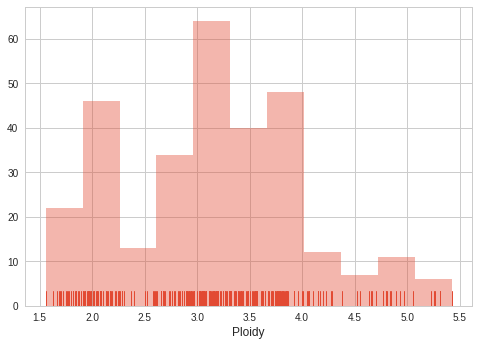

In [4]:
# ploidy 
df = [{'Patient' : p, 'Sample' : s, 'Ploidy' : plopur[p][s]['ploidy']} for p in plopur for s in plopur[p]]
sns.distplot(pd.DataFrame(df)['Ploidy'], kde=False, rug=True, norm_hist=False)

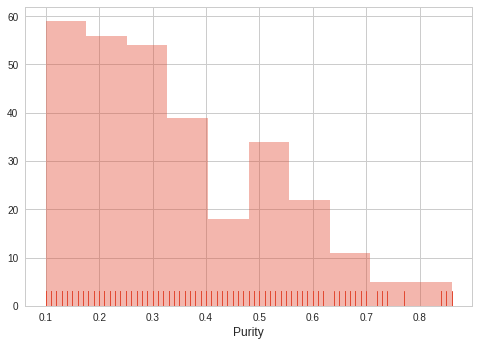

In [5]:
# ploidy 
df = [{'Patient' : p, 'Sample' : s, 'Purity' : plopur[p][s]['purity']} for p in plopur for s in plopur[p]]
sns.distplot(pd.DataFrame(df)['Purity'], kde=False, rug=True, norm_hist=False)

In [6]:
def findsegment(patient, ch, o):
    found = {}
    for sample in cnas[patient]:
        if ch not in cnas[patient][sample]:
            return None
        
        segs = sorted(cnas[patient][sample][ch], key=(lambda x : x[0]))
        
        L = 0
        R = len(segs) - 1

        if not (segs[0][0] <= o <= segs[-1][1]):
            return None
            continue
        if o == segs[L][0]:
            found[sample] = segs[L]
            continue
        if o == segs[R][1]:
            found[sample] = segs[R]
            continue

        while (R - L) > 1:
            M = int(round(float(R + L) / 2.0))
            if segs[L][0] <= o < segs[M][1]:
                R = M
            else:
                L = M
        if segs[L][0] <= o < segs[L][1]:
            found[sample] = segs[L]
            continue
        elif segs[R][0] < o <= segs[R][1]:
            found[sample] = segs[R]
            continue
        elif o == segs[L][1] and o == segs[R][0]:
            found[sample] = segs[R]
            continue
        elif o == segs[L][1]:
            found[sample] = segs[L]
            continue
        elif o == segs[R][0]:
            found[sample] = segs[R]
            continue
        else:
            return None
            assert False, '{} {} {} {}'.format(patient, sample, ch, o)
    return found

In [8]:
# Read SNVs 

snvs = {}
discarded = 0
discsamples = set()
contr = 0
with open('data/mutations.csv') as i:
    for idx, line in enumerate(i):
        if 0 <= idx <= 18:
            assert line[0] == '#'
        elif idx == 19:
            assert line.split()[0] == 'MutationID'
        else:
            parsed = line.strip().split('\t')
            if len(parsed) > 0:
                idx = parsed[0]
                patient = parsed[1]

                ch = parsed[2]
                assert int(ch) in range(1, 25), ch

                start = int(parsed[3])

                segs = findsegment(patient, ch, start)
#                if segs is None:
#                    discarded += 1
#                    continue
                
                assert segs is None or False not in set(segs[s][0] <= start <= segs[s][1] for s in segs)

                if patient not in snvs:
                    snvs[patient] = {}
                if ch not in snvs[patient]:
                    snvs[patient][ch] = {}

                assert idx not in snvs[patient][ch]

                vaf = parsed[14].split(';')
                ex = (lambda x : (int(x.split('/')[0]), int(x.split('/')[1])))
                tmp = {p.split(':')[0] : ex(p.split(':')[1]) for p in vaf if p.split(':')[0] in cnas[patient]}
                if False in set(tmp[p][0] <= tmp[p][1] for p in tmp):
#                     contr += 1
#                     continue
                    for p in tmp:
                        if tmp[p][1] < tmp[p][0]:
                            tmp[p] = (tmp[p][0], tmp[p][0])    
                #                assert False not in set(snv['counts'][p][0] <= snv['counts'][p][1] for p in snv['counts']), snv['counts']

                snvs[patient][ch][idx] = {}
                snv = snvs[patient][ch][idx]
                
                assert False not in set(tmp[p][0] <= tmp[p][1] for p in tmp)
                snv['counts'] = tmp
                
                tmp = set(p.split(':')[0] for p in vaf)
                if(tmp != set(cnas[patient])):
                    discsamples = discsamples.union(set((patient, s) for s in tmp.union(set(cnas[patient])) if s not in tmp or s not in set(cnas[patient])))
                
                snv['start'] = start
                snv['stop'] = int(parsed[4])
                ref = parsed[5]
                var = parsed[6]
                hugo = parsed[7]
                func = parsed[8]
                exfunc = parsed[9]
                snv['seg'] = segs
                snv['cnstate'] = {s : cnas[patient][s][ch][segs[s]] if segs else (1, 1) for s in snv['counts']}
                
print 'SNVs discarded because not covered by CNAs: {}'.format(discarded)
print 'SNVs with discordant counts: {}'.format(contr)
print 'Samples discarded because missing infered of either SNVs or CNAs: {}'.format(len(discsamples))

SNVs discarded because not covered by CNAs: 0
SNVs with discordant counts: 0
Samples discarded because missing infered of either SNVs or CNAs: 24


In [11]:
discsamples

{('CRUK0024', 'R2'),
 ('CRUK0027', 'R3'),
 ('CRUK0029', 'R1'),
 ('CRUK0042', 'R2'),
 ('CRUK0045', 'R2'),
 ('CRUK0052', 'R2'),
 ('CRUK0053', 'R1'),
 ('CRUK0055', 'R1'),
 ('CRUK0055', 'R3'),
 ('CRUK0055', 'R4'),
 ('CRUK0060', 'R2'),
 ('CRUK0065', 'R7'),
 ('CRUK0072', 'R3'),
 ('CRUK0074', 'R3'),
 ('CRUK0080', 'R2'),
 ('CRUK0081', 'R6'),
 ('CRUK0089', 'R1'),
 ('CRUK0091', 'R1'),
 ('CRUK0092', 'R2'),
 ('CRUK0093', 'R2'),
 ('CRUK0099', 'LN1'),
 ('CRUK0099', 'R2'),
 ('CRUK0099', 'R4'),
 ('CRUK0099', 'R5')}

In [9]:
for pat in snvs:
    with open('{}.input.tsv'.format(pat), 'w') as o:
        tch = list(snvs[pat])[0]
        tidx = list(snvs[pat][tch])[0]
        samples = sorted(list(snvs[pat][tch][tidx]['cnstate']))
        assert False not in set(set(snvs[pat][ch][idx]['cnstate']) == set(samples) for ch in snvs[pat] for idx in snvs[pat][ch])
        
        pos = [(ch, idx) for ch in sorted(snvs[pat], key=orderchrs) for idx in sorted(snvs[pat][ch])]
        
        o.write('{} #samples\n'.format(len(samples)))
        o.write('{} #characters\n'.format(len(pos)))
        o.write('#sample_index\tsample_label\tcharacter_index\tcharacter_label\tref\tvar\n')
        
        for k, sam in enumerate(samples):
            for n, p in enumerate(pos):
                ch = p[0]
                idx = p[1]
                alt = snvs[pat][ch][idx]['counts'][sam][0]
                ref = snvs[pat][ch][idx]['counts'][sam][1] - alt
                assert ref >= 0 and alt + ref == snvs[pat][ch][idx]['counts'][sam][1], ref
                r = '{}\t{}\t{}\t{}\t{}\t{}'.format(k, sam, n, idx, ref, alt)
                r += '\t{}\t{}\t{}'.format(1, 1, 1.0 - plopur[pat][sam]['purity'])
                r += '\t{}\t{}\t{}\n'.format(snvs[pat][ch][idx]['cnstate'][sam][0], snvs[pat][ch][idx]['cnstate'][sam][1], plopur[pat][sam]['purity'])
                o.write(r)
                    

In [10]:
maxcn = 4
for pat in snvs:
    with open('{}.capped4.input.tsv'.format(pat), 'w') as o:
        tch = list(snvs[pat])[0]
        tidx = list(snvs[pat][tch])[0]
        samples = sorted(list(snvs[pat][tch][tidx]['cnstate']))
        assert False not in set(set(snvs[pat][ch][idx]['cnstate']) == set(samples) for ch in snvs[pat] for idx in snvs[pat][ch])
        
        pos = [(ch, idx) for ch in sorted(snvs[pat], key=orderchrs) for idx in sorted(snvs[pat][ch])]
#        pos = [x for x in tmp if max(max(i) for i in snvs[pat][x[0]][x[1]]['cnstate'].values()) <= maxcn]
#        disc[pat] = (len(tmp), len(tmp) - len(pos))
        
        o.write('{} #samples\n'.format(len(samples)))
        o.write('{} #characters\n'.format(len(pos)))
        o.write('#sample_index\tsample_label\tcharacter_index\tcharacter_label\tref\tvar\n')
        
        for k, sam in enumerate(samples):
            for n, p in enumerate(pos):
                ch = p[0]
                idx = p[1]
                alt = snvs[pat][ch][idx]['counts'][sam][0]
                ref = snvs[pat][ch][idx]['counts'][sam][1] - alt
                assert ref >= 0 and alt + ref == snvs[pat][ch][idx]['counts'][sam][1], ref
                r = '{}\t{}\t{}\t{}\t{}\t{}'.format(k, sam, n, idx, ref, alt)
                r += '\t{}\t{}\t{}'.format(1, 1, 1.0 - plopur[pat][sam]['purity'])
                cnA = min(snvs[pat][ch][idx]['cnstate'][sam][0], maxcn)
                cnB = min(snvs[pat][ch][idx]['cnstate'][sam][1], maxcn)
                r += '\t{}\t{}\t{}\n'.format(cnA, cnB, plopur[pat][sam]['purity'])
                o.write(r)
                    

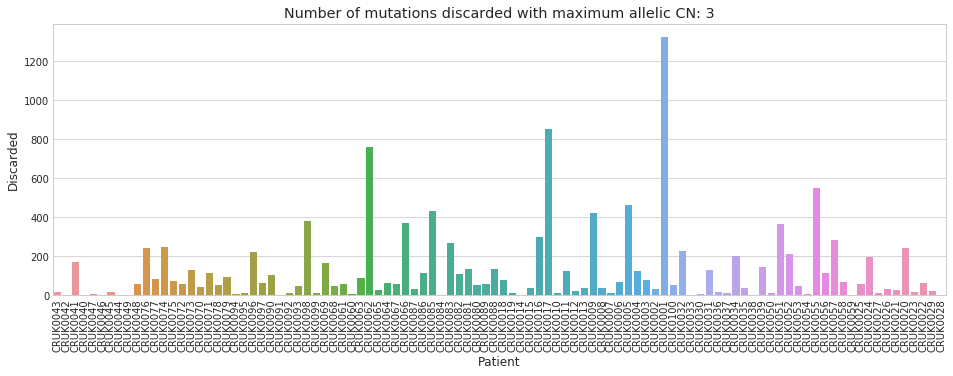

In [31]:
df = [{'Patient' : i, 'Discarded' : disc[i][1]} for i in disc]
plt.figure(figsize=(16, 5))
g = sns.barplot(data=pd.DataFrame(df), x='Patient', y='Discarded')
plt.xticks(rotation=90)
plt.title('Number of mutations discarded with maximum allelic CN: {}'.format(maxcn))
plt.savefig('plot.pdf', bbox_inches='tight')

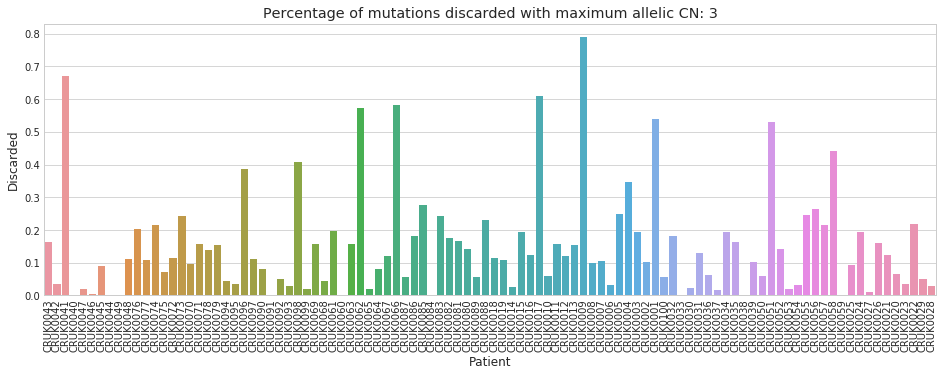

In [32]:
df = [{'Patient' : i, 'Discarded' : disc[i][1] / float(disc[i][0])} for i in disc]
plt.figure(figsize=(16, 5))
g = sns.barplot(data=pd.DataFrame(df), x='Patient', y='Discarded')
plt.xticks(rotation=90)
plt.title('Percentage of mutations discarded with maximum allelic CN: {}'.format(maxcn))
plt.savefig('plot.pdf', bbox_inches='tight')

CRUK0043
CRUK0042
CRUK0041
CRUK0040
CRUK0047
CRUK0046
CRUK0045
CRUK0044
CRUK0049
CRUK0048
CRUK0076
CRUK0077
CRUK0074
CRUK0075
CRUK0072
CRUK0073
CRUK0070
CRUK0071
CRUK0078
CRUK0079
CRUK0094
CRUK0095
CRUK0096
CRUK0097
CRUK0090
CRUK0091
CRUK0092
CRUK0093
CRUK0098
CRUK0099
CRUK0069
CRUK0068
CRUK0061
CRUK0060
CRUK0063
CRUK0062
CRUK0065
CRUK0064
CRUK0067
CRUK0066
CRUK0087
CRUK0086
CRUK0085
CRUK0084
CRUK0083
CRUK0082
CRUK0081
CRUK0080
CRUK0089
CRUK0088
CRUK0018
CRUK0019
CRUK0014
CRUK0015
CRUK0016
CRUK0017
CRUK0010
CRUK0011
CRUK0012
CRUK0013
CRUK0009
CRUK0008
CRUK0007
CRUK0006
CRUK0005
CRUK0004
CRUK0003
CRUK0002
CRUK0001
CRUK0100
CRUK0032
CRUK0033
CRUK0030
CRUK0031
CRUK0036
CRUK0037
CRUK0034
CRUK0035
CRUK0038
CRUK0039
CRUK0050
CRUK0051
CRUK0052
CRUK0053
CRUK0054
CRUK0055
CRUK0056
CRUK0057
CRUK0058
CRUK0059
CRUK0025
CRUK0024
CRUK0027
CRUK0026
CRUK0021
CRUK0020
CRUK0023
CRUK0022
CRUK0029
CRUK0028


[(0, 10)]

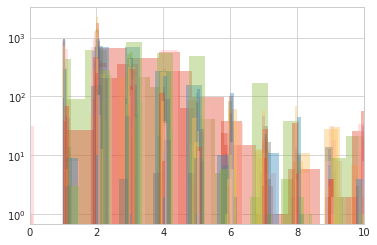

In [17]:
for pat in snvs:
    mc = [max([max(snvs[pat][ch][s]['cnstate'][p]) for p in snvs[pat][ch][s]['cnstate']]) for ch in snvs[pat] for s in snvs[pat][ch]]
    g = sns.distplot(mc, kde=False, norm_hist=False, hist_kws={'log':True}, bins=100)
    print pat
    
g.set(xlim=(0, 10))